Pada proyek belajar machine learning ini menggunakan dataset Brain Tumor Images (https://www.kaggle.com/datasets/adityakomaravolu/brain-tumor-mri-images) dari kaggle. Pada dataset ini dilakukan oversampling agar data setiap kelas balance dengan cara menduplikat images. Model yang digunakan mengimplementasikan transfer learning dari MobileNetV2 yang menghasilkan akurasi diatas 90% dan validation accuracy diatas 85%.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import scipy
import os
import cv2

In [2]:
train_dir = "dataset/train"

batch_size = 32
img_height = 224
img_width = 224

In [3]:
train_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode= 'categorical'
)

Found 6380 files belonging to 4 classes.
Using 5104 files for training.


In [4]:
val_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode= 'categorical'
)

Found 6380 files belonging to 4 classes.
Using 1276 files for validation.


In [5]:
class_names= train_data.class_names
print(class_names)

['glioma', 'meningioma', 'notumor', 'pituitary']


In [7]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
  ])

In [8]:
pre_trained_model = MobileNetV2(weights="imagenet", include_top=False,
                                input_tensor=Input(shape=(224, 224, 3)))

pre_trained_model.trainable = False

In [9]:
model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),
    pre_trained_model,
    tf.keras.layers.Flatten(name="flatten"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation="softmax")
])

model.build(input_shape = (224, 224, 3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dropout (Dropout)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 32)                2007072   
                                                      

In [10]:
int_lr = 1e-4
num_epochs = 50

optimizer = tf.optimizers.Adam(lr=int_lr)
model.compile(optimizer=optimizer,
              loss="categorical_crossentropy",
              metrics=['accuracy'])

F:\Anaconda\envs\gpu2\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [11]:
class custom_callbacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        if logs.get('accuracy') >= 90e-2 and logs.get('val_accuracy') > 85e-2:
            print('\nFor Epoch', epoch, '\nAccuracy has reach = %2.2f%%' %(logs['accuracy']*100), 
                  'and Validation Accuracy has reach = %2.2f%%' %(logs['val_accuracy']*100), 'training has been stopped.')
            self.model.stop_training = True

In [12]:
H = model.fit(train_data,
              epochs=num_epochs,
              validation_data=val_data,
              callbacks=[custom_callbacks()])

Epoch 1/50
160/160 [==============================] - 169s 865ms/step - loss: 0.8662 - accuracy: 0.6513 - val_loss: 0.5119 - val_accuracy: 0.8190
Epoch 2/50
160/160 [==============================] - 113s 704ms/step - loss: 0.4922 - accuracy: 0.8286 - val_loss: 0.4862 - val_accuracy: 0.8354
Epoch 3/50
160/160 [==============================] - 114s 713ms/step - loss: 0.4003 - accuracy: 0.8619 - val_loss: 0.4813 - val_accuracy: 0.8393
Epoch 4/50
160/160 [==============================] - 115s 714ms/step - loss: 0.3503 - accuracy: 0.8756 - val_loss: 0.7356 - val_accuracy: 0.7994
Epoch 5/50
160/160 [==============================] - 113s 701ms/step - loss: 0.3166 - accuracy: 0.8909 - val_loss: 0.4589 - val_accuracy: 0.8425
Epoch 6/50
160/160 [==============================] - 120s 745ms/step - loss: 0.2895 - accuracy: 0.9056 - val_loss: 0.5891 - val_accuracy: 0.8213
Epoch 7/50
160/160 [==============================] - 112s 700ms/step - loss: 0.2423 - accuracy: 0.9136 - val_loss: 0.4846 -

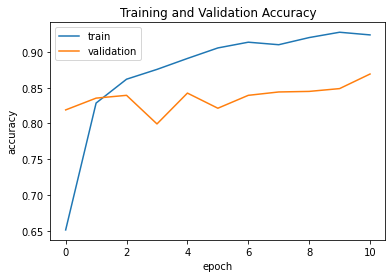

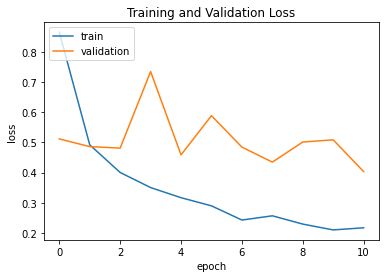

In [13]:
plt.plot(H.history['accuracy'], label='train')
plt.plot(H.history['val_accuracy'], label='validation')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(H.history['loss'], label='train')
plt.plot(H.history['val_loss'], label='validation')
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [14]:
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


In [15]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [16]:
tflite_model_file = pathlib.Path('brain_tumors_2.tflite')
tflite_model_file.write_bytes(tflite_model)

16940352